<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка
Первым делом, перед самой работой, нам надо импортировать библиотеки, которые помогут нам работать с данными:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

import time

После импорта библиотек необходимо сохранить доступные нам данные в переменную `data`, используя библиотеку `pandas` и его метод `read_csv`. Из аргументов `read_csv` мы добавим: `index_col` - столбцы для использования в качестве меток строк DataFrame (дату будем использовать как индексы строк),  `parse_dates` - разобрать столбцы как отдельный столбец даты. После чтения данныхх, делаем сортировку индексов, чтобы данные начинались с наименьшего до наибольшего, методом `sort_index`:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Как можно заметить, в нашей таблице всего два признака:
- дата 
- количество заявок на выбранную дату

При работе с временными данными следует соблюдать порядок дат, чтобы раннее время было в начале, а самое позднее в конце. Для проверки соблюдения порядка используем метод `index` и его метод `is_monotonic`. Если возвращается True, то все верно, иначе вернется False, что говорит нам об ошибке порядка дат

In [3]:
print(data.index.is_monotonic)

True


После наших преобразований давайте проверим краткую информацию о нашей таблице: 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы подготовили данные, которые готовы к дальнейшей работе, поэтому можно приступить к анализу таблицы 

## Анализ
На этапе анализа таблицы, мы займемся анализом графиков движения количества заказов. Первым делом сделаем ресемплирование данных по одному часу и взглянем на график изменения суммы заказов. Потом возьмем скользящее среднее по 10-ти значениям и посмотрим, как меняется среднее значение со временем. Ну и в конце попробуем взять тренд по первым 15-м значениям и посмотрим, куда направлен тренд

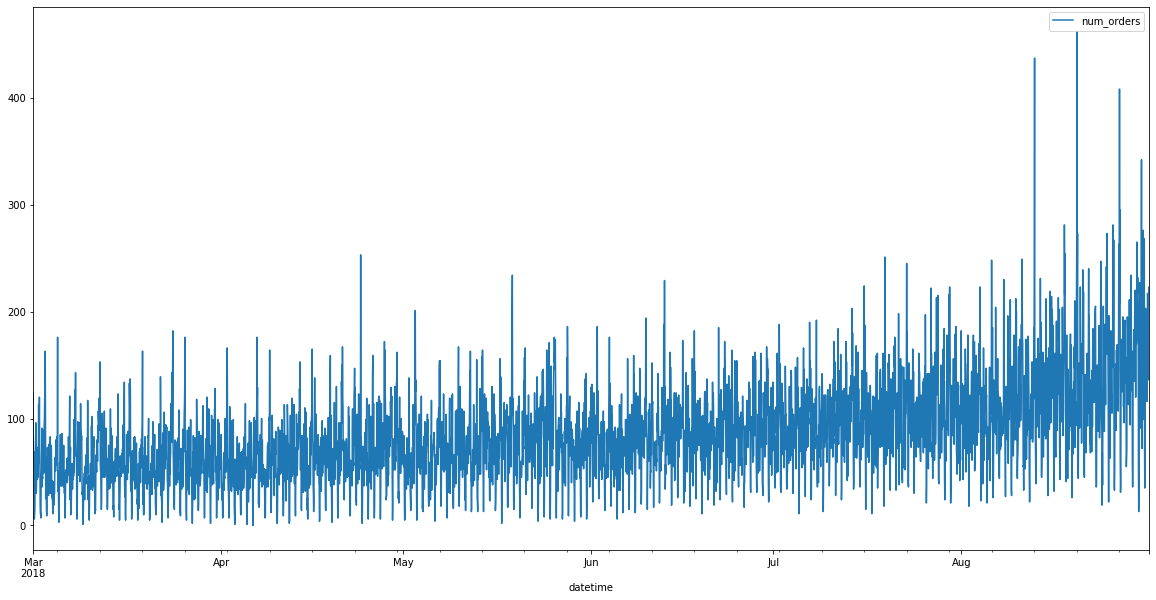

In [5]:
data = data.resample('1H').sum()

data.plot(figsize=(20,10))

Как можно заметить по графику выше, суммарное количество заявок увеличивается в восходящем виде. Если в Марте мы начинали в коридоре от 0 до 100, то в Августе перешгли в коридор от 60 до 200. Давайте посмотрим на изменение среднего значения заявок, используя метод `rolling` с размером окна 10

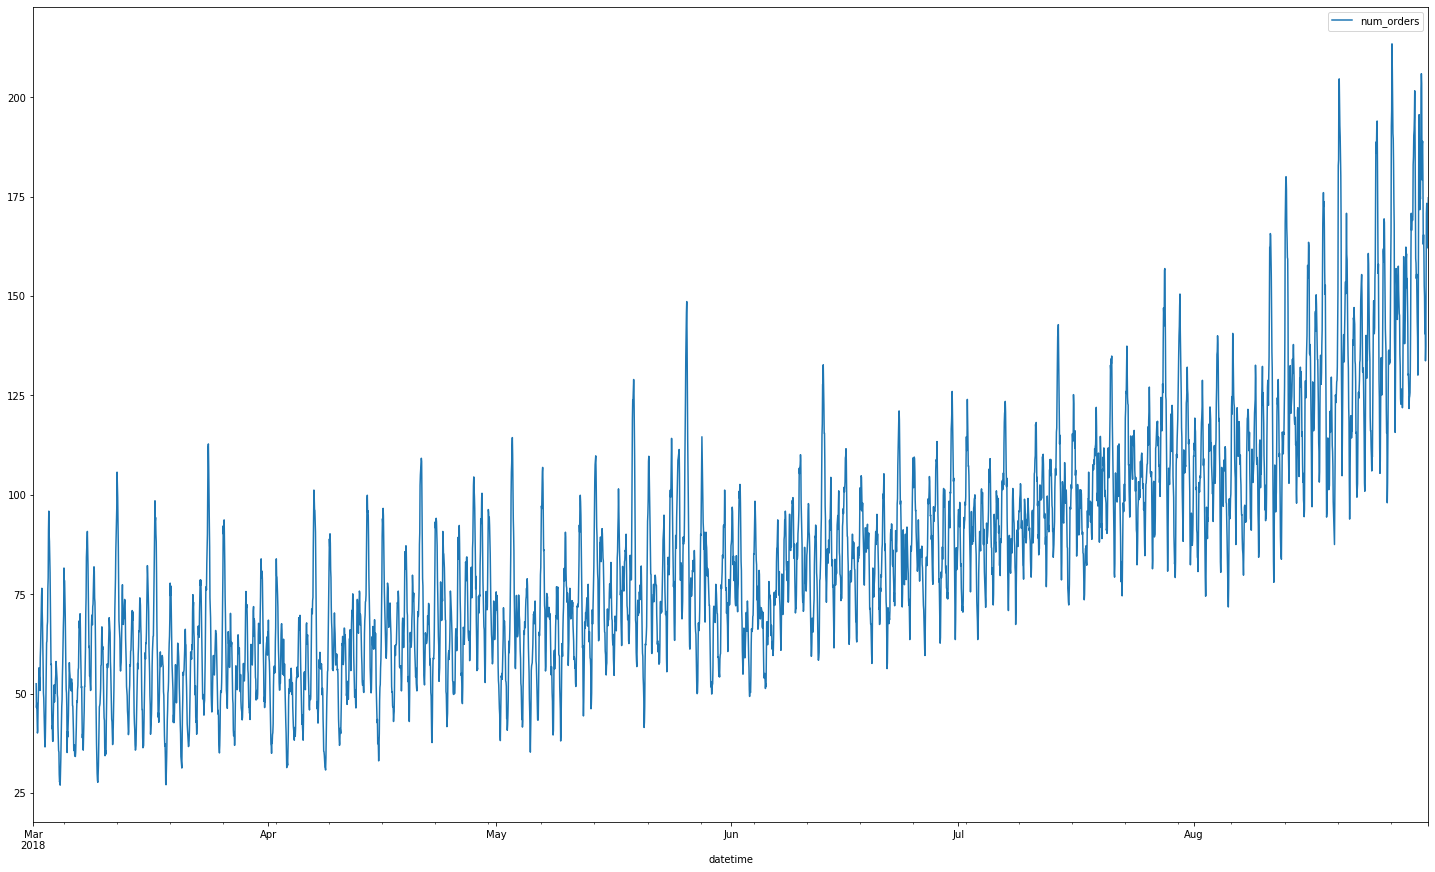

In [6]:
data.rolling(10).mean().plot(figsize=(25,15))

По среднему изменению количества заявок можно сделать вывод, что оно увеличивается и сильно. В Марте было 50 заявок, а вот в Августе уже 90-100. Далее давайте изучим график тренда. Для изучения тренда мы будем использовать библиотеку `statsmodels` и метод `tsa`, внутри которого есть еще один метод - `seasonal` и оттуда мы воспользуемся методом `seasonal_decompose`, который позволит нам изучать тренды и сезонность. Месяц будет как раз кстати

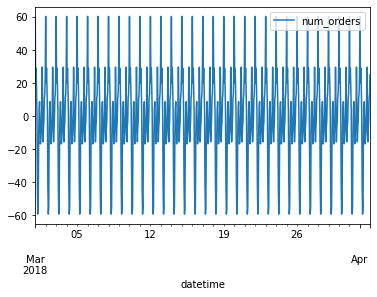

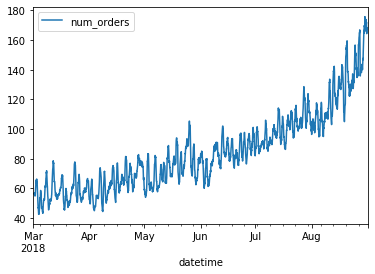

In [7]:
decomposed = seasonal_decompose(data)

decomposed_seasonal_month = decomposed.seasonal['2018-03-01':'2018-04-01']
decomposed_seasonal_month.plot()

decomposed_trend = decomposed.trend
decomposed_trend.plot()

По тренду видно следующее - локальные минимумы становятся все меньше и меньше (их глубина уменьшается), а значит, график идет вверх. Уже сейчас можно сказать, что количество заявок начнет только увеличиваться и стоит ожидать новых клиентов

## Обучение
После анализа данных можно приступить к обучению модели `линейной регрессии`, `случайного леса` и `градиентного бустинга`. Но для того, чтобы качество было как можно выше, мы будем перебирать параметры лучшей модели. Для выполнения работы мы создадим две функции, одна из которых будет создавать признаки, а другая сделает выполнение метрики rmse. Также при обучении мы будем использовать кросс-валидацию по 5 блокам, но это будет не просто `KFold` (метод выполнения кросс-валидации), а `TimeSeriesSplit`, так как при работе с временными рядами нельзя использовать стандартную кросс-валидацию, ведь в определенный момент тренировочная выборка окажется позже валидационной.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = pd.DataFrame()
    new_data = data.copy()
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

Выше создана функция, которая создает новые признаки для нашей таблицы данных

In [9]:
def do_rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    return mse**0.5

А здесь изображена функция, решающая rmse для входящих данных. Именно эту функцию  мы будем использовать при кросс-валидации как метрику

Первым делом после создания функций мы инициализируем рабочую выборку данных и обучаемый с тестовым датасетами, где определим признаки и целевой таргет

In [10]:
new_data = make_features(data, 23, 10)

train, test = train_test_split(new_data, test_size=0.1, shuffle=False)
train = train.dropna()


train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Отлично, теперь можно инициализировать алгоритмы машинного обучения: линейная регрессия, случайный лес и градиентный бустинг

In [11]:
model_linear = LinearRegression()
model_forest = RandomForestRegressor()
model_LGBMR = LGBMRegressor()

Теперь можно начать работу с кросс-валидацией и получением rmse от каждого алгоритма. Первым алгоритмом будет линейная регрессия

In [12]:
tscv = TimeSeriesSplit(n_splits=5)

my_scorer = make_scorer(do_rmse, greater_is_better=True)
linear_regression_rmse = np.mean(cross_val_score(model_linear, train_features, train_target, scoring=my_scorer, cv=tscv))

print(linear_regression_rmse)

29.538182051193054


Результат неплохой - 29.54, однако давайте проверим еще два наших алгоритма. Следующий на очереди случайный лес

In [13]:
forest_regressor_rmse = np.mean(cross_val_score(model_forest, train_features, train_target, scoring=my_scorer, cv=tscv))

print(forest_regressor_rmse)

27.98946505064249


У случайного леса получилось 28, что лучше линейной регрессии на 1.5 значения. Отлично! Последний алгоритм - градиентный бустинг

In [14]:
LGBMR_regression_rmse = np.mean(cross_val_score(model_LGBMR, train_features, train_target, scoring=my_scorer, cv=tscv))

print(LGBMR_regression_rmse)

26.611936543513842


Градиентный бустинг показал нам результат равный 26.6, что делает его лучшим методом из наших трех. Но это еще не все, теперь нам нужно подобрать такие параметры, при которых модель градиентного бустинга сможет показать свой наилучший результат. В качестве гиперпараметров, которые мы будем настраивать будут: скорость обучения, количество деревьев модели и глубина деревьев

In [15]:
%%time

lr_rates = [0.001, 0.01, 0.1, 1]
best_score = 100
best_model = None

for trees in range(100, 600, 100):
    for depth in range(7, 16):
        for lr_rate in lr_rates:
            model_LGBMR = LGBMRegressor(n_estimators=trees, max_depth=depth, learning_rate=lr_rate)
            LGBMR_regression_rmse = np.mean(cross_val_score(model_LGBMR, train_features, train_target, scoring=my_scorer, cv=tscv))

            print(LGBMR_regression_rmse)
            
            if best_score > LGBMR_regression_rmse:
                best_score = LGBMR_regression_rmse
                best_model = model_LGBMR
                
print("Лучший результат при подборе параметров показал:", best_score)
print("А сама модель имеет следующие параметры:", best_model)

39.01579885182391
31.235269530747303
26.60698431520375
34.74242721152988
38.92234008853987
31.112851772672677
26.582908673016505
34.2148573481477
38.88204743727569
31.07333843046307
26.667344337808924
34.94797191168121
38.870632373855884
31.047123163390456
26.65797121207608
34.32891304304682
38.874300417326296
31.05023932604514
26.66529788114422
35.05145541153412
38.877475591066585
31.059494170368573
26.7529969196007
35.11375046579484
38.877475591066585
31.05158747714317
26.741207815586584
35.0403283639443
38.877475591066585
31.056115589439948
26.623543076958686
34.10663409644978
38.877475591066585
31.056115589439948
26.607720733224436
34.37380100370366
37.66377404549244
28.404247755327027
26.632391752957993
34.77471225606777
37.55936022103541
28.27689245586069
26.693196651728737
34.21385257529603
37.490424191044646
28.2735572805193
26.722038945096493
34.92975670116886
37.46069700296794
28.284456850978625
26.762033192776727
34.339988966047464
37.47034416821129
28.25983695526191
26.7235

Как видно, настройка параметров дала нам результат, который не сильно отличается от дефолтного - всего 26.58, что на 0.03 лучше оригинала

## Тестирование
Последний этап нашей работы - проверка на тестовых значениях, а также проверка с медианной моделью, вдруг данная модель будет давать результат повыше, чем наш градиентный бустинг. Для количества отстающих значений мы будем использовать значение = 23, а также окно скользящего среднего равного 10. Гиперпараметры градиентного бустинга сохранены в переменной best_model, именно ее мы и используем

In [16]:
test_LGBMR_regression_rmse = np.mean(cross_val_score(best_model, test_features, test_target, scoring=my_scorer, cv=tscv))

print(test_LGBMR_regression_rmse)

46.063498608001375


Результат равен 46.06, что лучше, чем граница допустимого значения, по условию задачи. Но давайте проверим медианную модель

In [17]:
dummy = DummyRegressor(strategy="median") # создаем нашу константную модель, которая считает по медиане
dummy.fit(train_features, train_target) # обучаем модель 
dummy_pred = dummy.predict(test_features) # получаем предсказывания с модели
 
rmse_dummy = mean_squared_error(test_target, dummy_pred)**0.5 # получаем данные с метрики sMAPE
print('rmse_dummy от dummy:', rmse_dummy)

rmse_dummy от dummy: 87.15277582981295


Как итог, у нас вышло, что градиентный бустинг показал результат почти в два раза лучше, чем медианная и ниже, чем 48, отлично, задача решена! Однако давайте посмотрим на результат предсказания модели - визуализируем его

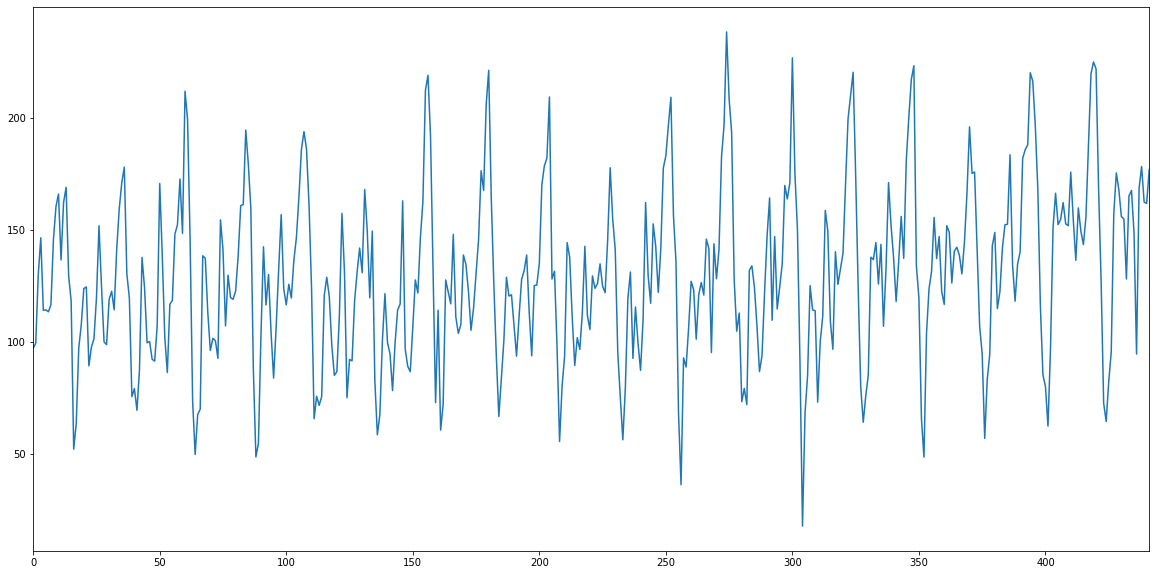

In [18]:
best_model.fit(train_features, train_target)
predictions = best_model.predict(test_features)
predictions = pd.Series(data=predictions)
predictions.plot(figsize=(20,10))

## Вывод
В заключении, стоит отметить следующее:
- Наши данные содержали всего два признака: дата и количество заявок на дату
- Даты были приведены в индексы строк
- пропусков обнаружено не было
- по анализу ресемплирования можно заметить восходящий тренд, также как и по скользящему среднему 
- если брать сам тренд количества заявок, то он также идет вверх
- при обучении модели были выбраны три модели: случайный лес, градиентный бустинг и линейная регрессия, среди которых наилучшей моделью оказался градиентный бустинг
- было выбрано значение 23 для количества отстающих значений, ведь чем больше, тем сложнее модель, хоть и лучше 
- были выбраны гиперпараметры для градиентного бустинга: количество деревьев = 100, глубина = 8 и скорость обучения = 0.1
- качество на тестовой выборке у линейной регрессии 46.06, в то время как у медианной всего 87.15

Задание выполнено, качество не выше 48

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48